# get financial data

[yahoo_fin](http://theautomatic.net/yahoo_fin-documentation/#installation)を使う。

## installation

```bash
$ pip install yahoo_fin
```

## memo


- get [summary](https://finance.yahoo.com/quote/GOOGL?p=GOOGL)
    - `si.get_quote_table(ticker)`
```
1y Target Est
52 Week Range
Ask
Avg. Volume
Beta (5Y Monthly)
Bid
Day's Range
EPS (TTM)
Earnings Date
Ex-Dividend Date
Forward Dividend & Yield
Market Cap
Open
PE Ratio (TTM)
Previous Close
Quote Price
Volume
```
- get [statistics](https://finance.yahoo.com/quote/GOOGL/key-statistics?p=GOOGL)
    - `si.get_stats_valuation(ticker)`
```
Market Cap (intraday) 5
Enterprise Value 3
Trailing P/E
Forward P/E 1
PEG Ratio (5 yr expected) 1
Price/Sales (ttm)
Price/Book (mrq)
Enterprise Value/Revenue 3
Enterprise Value/EBITDA 7
```
上記末尾の数字は，Yahoo Financeのサイトの各項目の注釈番号
- get [analytics](https://finance.yahoo.com/quote/GOOGL/analysis?p=GOOGL)
    - `si.get_analysts_info(ticker)`
```
Earnings Estimate
Revenue Estimate
Earnings History
EPS Trend
EPS Revisions
Growth Estimates
```

- get earnings history
    - `si.get_earnings_history(ticker)`
    - EPS actual/estimate


## references

- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)

In [14]:
ticker="SQ"
#df=si.get_quote_table(ticker)
#df=si.get_stats_valuation(ticker)
#dic_tmp=si.get_analysts_info(ticker)
#dic_earnings=si.get_earnings_history(ticker)
#display(df)

In [34]:
import yahoo_fin.stock_info as si
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

    
def defaultPlotting(): 
    sns.set(rc={'figure.figsize':(6,4),
                "axes.titlesize":20,
                "axes.labelsize":20,
                "font.size":20,
                "legend.fontsize":15
               },style="white")
    sns.set_style("whitegrid")

    
def today():
    return(datetime.today().strftime('%Y-%m-%d'))
  

In [31]:
# Usage: plot EPS history
# ticker=["SQ"]
# df_earnings=get_earnings_history(ticker)
# plot_eps(df_earnings)

def _get_earnings_history(ticker):
    dct=si.get_earnings_history(ticker)
    df=pd.json_normalize(dct)
    df["startdatetime"]=df["startdatetime"].str.replace(r'T.*$','',regex=True)
#    df=df.set_index("startdatetime").sort_index()
#    df["Ticker"]=ticker
    return(df)

def get_earnings_history(tickers):
    df=_get_earnings_history(tickers[0])

    for ticker in tickers[1:]:
        tmp=_get_earnings_history(ticker)
        df=df.append(tmp)

    return(df)

def _plot_eps(df,ax,last):
    d=df.set_index("startdatetime").sort_index().tail(last)
    sns.lineplot(ax=ax,data=d[["epsactual","epsestimate"]],marker='o')
    ax.set_title(d["ticker"][0])
    ax.tick_params(axis='x', labelrotation = 90)        

    ax.set_xlabel("")
    ax.set_ylabel("EPS")
    
def plot_eps(df,last=1000):
    tickers=df.ticker.unique()
    n_tick=len(tickers)
    if n_tick <= 3:
        max_col=n_tick
    elif n_tick == 4:
        max_col=2
    elif n_tick <= 6:
        max_col=3
    else:
        max_col=3
#        max_col=4

    n_tick=len(tickers)
    n_col=min(n_tick,max_col)
    n_row=(n_tick-1)//max_col+1
#    print("ntick: {}, nrow: {}, ncol: {}".format(n_tick, n_row, n_col))

    defaultPlotting()
    fig, axes = plt.subplots(n_row, n_col, figsize=(6*n_col,4*n_row))
    fig.suptitle("EPS history within last {} quarters ({})".format(last,today()))

    for i, ticker in enumerate(tickers):
        target = df[df["ticker"]==ticker]
                   
        if n_row == 1:
            if n_tick==1:
                ax=axes
            else:
                ax=axes[i]
        else:
            row=i//n_col
            col=i%n_col
            ax=axes[row,col]

        _plot_eps(target,ax, min(last,len(target)))
        
    fig.tight_layout()
    plt.show()

In [53]:
def _get_ticker_data(ticker):
    data_qt = si.get_quote_table(ticker)
    data_val=si.get_stats_valuation(ticker)

    df_qt=pd.DataFrame.from_dict(data_qt, orient='index')\
        .reset_index()\
        .rename(columns={"index":"info",0:"values"})
    df_val=data_val.rename(columns={0:"info",1:"values"})
    df=pd.concat([df_qt,df_val], ignore_index=True).sort_values(by="info")
    df["Ticker"]=ticker
    return(df)

def get_ticker_data(tickers):

    data = pd.DataFrame(index=[],columns=["Ticker","info","values"])

    for ticker in tickers:
        tmp=_get_ticker_data(ticker)
        data=data.append(tmp, ignore_index=True)
    
    df=data.pivot(index="Ticker",columns="info",values="values")
    
    return(df)

def col_name(df,str):
    return([col for col in df.columns if str in col])


def plot_financials(df,table=False):
    
    PSR=col_name(df,"Price/Sales")
    PBR=col_name(df,"Price/Book")
    PER=col_name(df,"PE Ratio")
    EPS=col_name(df,"EPS")
    Target=col_name(df,"Target")
    Cap=["Market Cap"]
    Date=col_name(df,"Earnings Date")
    Dividend=col_name(df,"Forward Dividend")
    Price=col_name(df,"Close")

#    numeric=Price+Target+PSR+PER+PBR+EPS
    numeric=Price+Target+PSR+PER+PBR

    df[numeric]=df[numeric].astype("float")
    
#     df[PSR].plot(kind="hist",bins=20)
#     plt.xlabel("PSR")
#     plt.show()

#    sns.set_theme()
    defaultPlotting()
    ax=sns.histplot(data=df[PSR],bins=20).set_title("PSR histogram ({})".format(today()))
    plt.xlabel("PSR")
    plt.show()
    
    target=Cap+numeric+Date
    df_tgt=df[target].sort_values(by=PSR, ascending=False)

    if table==True:
        print(today())
        display(df_tgt)
    else:
        print("{} High PSR stocks (Top 5)".format(today))
        display(df_tgt.head())

    
    return(df_tgt)

In [5]:
# get ticker list
tickers_dow = si.tickers_dow()
tickers_nasdaq=si.tickers_nasdaq()
tickers_sp500=si.tickers_sp500()
tickers_other=si.tickers_other()

display(len(tickers_dow))
display(len(tickers_nasdaq))
display(len(tickers_sp500))
display(len(tickers_other))

## Get data! It takes a while, so please be patient!

In [52]:
# get data of stock indexes
#df_dow=get_tickers_data(tickers=tickers_dow)
#df_nasdaq=get_tickers_data(tickers=tickers_nasdaq)
#df_sp500=get_tickers_data(tickers=tickers_sp500)

## Now, it's time to enjoy!

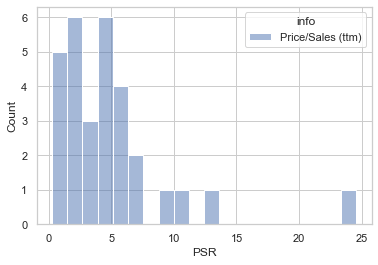

2021-07-12 High PSR stocks (Top 5)


info,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),EPS (TTM),Earnings Date
Ticker,,,,,,,
V,236.61,268.08,24.57,49.29,14.83,4.84,"Jul 27, 2021"
MSFT,277.42,298.92,13.09,37.88,15.57,7.34,"Jul 27, 2021"
CRM,245.80,278.66,10.15,51.67,5.33,4.74,"Aug 23, 2021 - Aug 27, 2021"
MCD,232.84,258.34,8.96,34.20,NaN,6.89,"Jul 28, 2021"
AAPL,143.24,159.34,7.44,32.62,35.00,4.45,"Jul 28, 2021 - Aug 02, 2021"


In [119]:
# show data
df_dow_final=show_info(df_dow,table=False)

## Get stock info of your favorite
### Tech

In [28]:
fangam=["FB","AAPL","NFLX","GOOG","AMZN","MSFT"]

###
ant=["ADBE","NVDA","TSLA"]
saas=["CRWD","OKTA","TTD","TWLO"]
fintech=["SQ","DOCU"]
growth1=ant+saas+fintech


###
ecommerce=["SHOP","ETSY","FIVN"]
sns=["TWTR","PINS"]
techs=["U","ZM","FVRR","ABNB"]
growth2=ecommerce+sns+techs

###
eauto=["F","GM","MGA"]

### check eps history

In [22]:
def get_all_data(ticker):
    # get eps history
    df_earnings=get_earnings_history(ticker)
    # get PSR and others
    df_ticker=get_ticker_data(ticker)
    return(df_earnings,df_ticker)

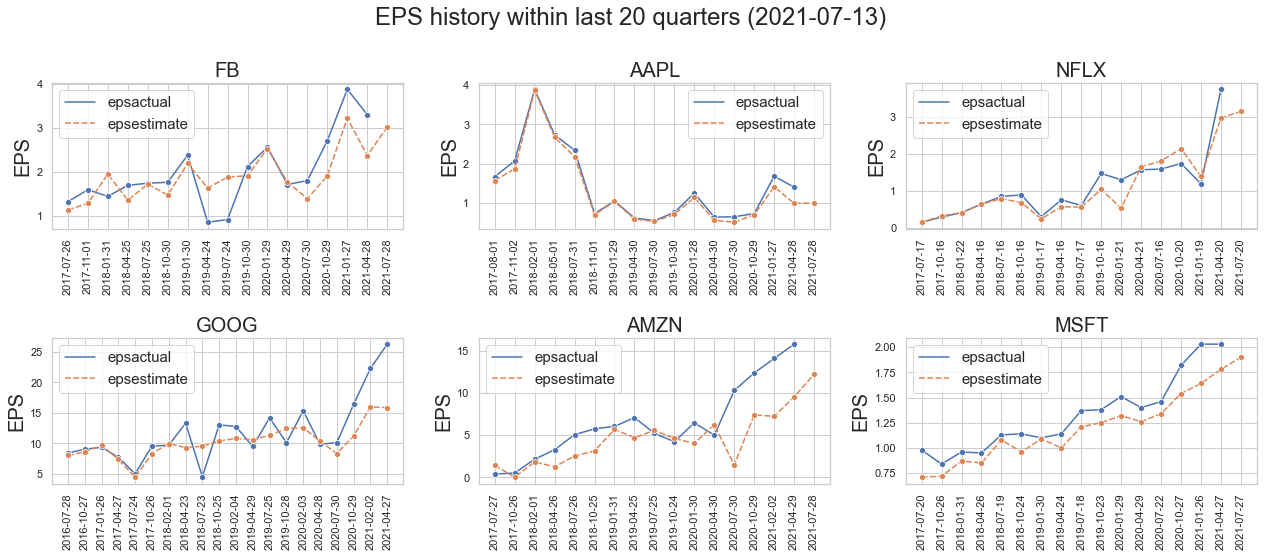

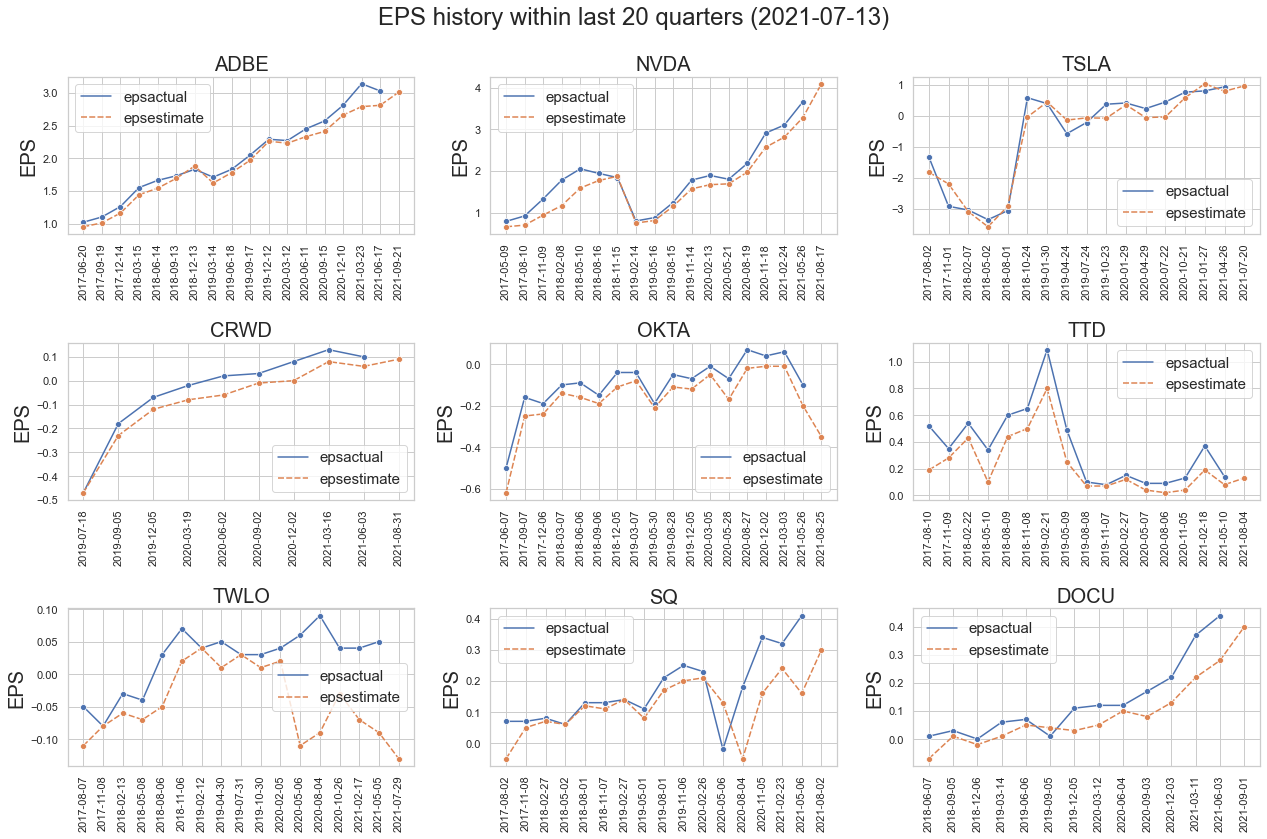

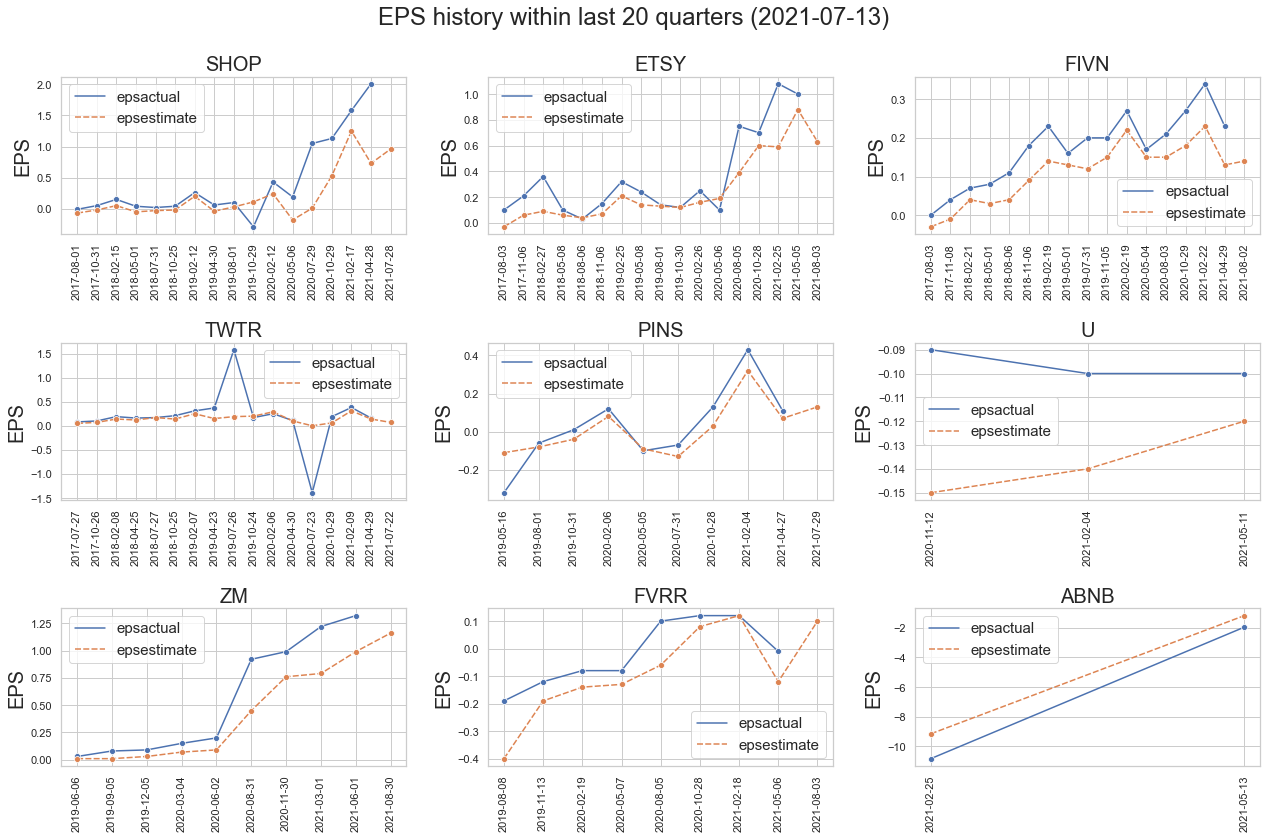

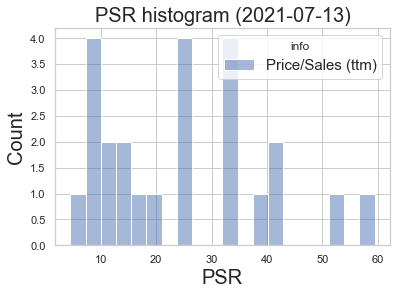

2021-07-13


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),EPS (TTM),Earnings Date
Ticker,,,,,,,,
CRWD,59.429B,264.44,268.08,59.48,NaN,69.96,-0.72,"Aug 31, 2021 - Sep 06, 2021"
SHOP,183.515B,1494.99,1515.09,53.18,116.04,20.16,12.79,"Jul 28, 2021"
OKTA,37.778B,251.84,277.00,41.81,NaN,48.29,-2.46,"Aug 25, 2021 - Aug 30, 2021"
TTD,36.413B,77.95,69.71,40.68,156.71,33.53,0.49,"Aug 04, 2021 - Aug 09, 2021"
FVRR,8.459B,240.82,258.88,37.82,NaN,48.95,-2.29,"Aug 03, 2021 - Aug 09, 2021"
DOCU,56.204B,288.02,281.17,34.58,NaN,230.96,-1.08,"Sep 01, 2021 - Sep 06, 2021"
U,29.043B,106.53,123.05,34.57,NaN,NaN,NaN,"Aug 10, 2021"
ZM,111.653B,385.08,415.48,34.05,130.67,26.62,2.90,"Aug 30, 2021 - Sep 03, 2021"
TWLO,67.658B,392.27,463.28,34.05,NaN,6.54,-3.92,"Jul 29, 2021"


In [52]:
#df_fangam_eps,df_fangam_fin=get_all_data(fangam)
plot_eps(df_fangam_eps,last=20)

#df_growth1_eps,df_growth1_fin=get_all_data(growth1)
plot_eps(df_growth1_eps,last=20)

#df_growth2_eps,df_growth2_fin=get_all_data(growth2)
plot_eps(df_growth2_eps,last=20)

# all PSR
df_fin=pd.concat([df_fangam_fin,df_growth1_fin,df_growth2_fin])
df_res=plot_financials(df_fin, table=True)

## Health

In [41]:
tickers_health=["ANTM","BMY","BNTX","BIIB","MRNA","PGNY","PFE","RPRX","VEEV"]

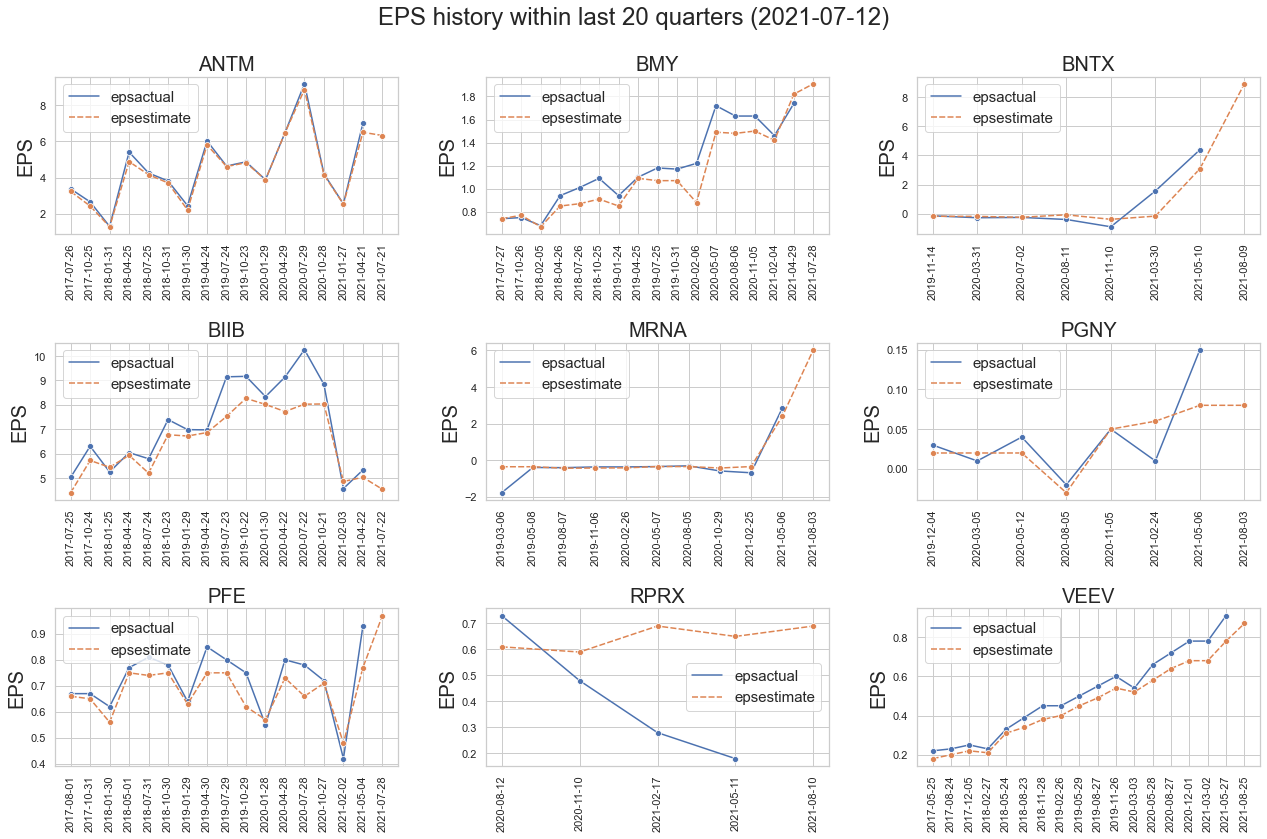

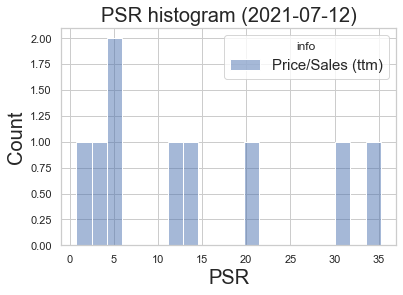

2021-07-12


info,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),EPS (TTM),Earnings Date
Ticker,,,,,,,
MRNA,232.81,184.92,35.24,159.99,24.97,1.49,"Aug 03, 2021 - Aug 09, 2021"
VEEV,321.41,333.14,31.21,126.98,20.08,2.53,"Aug 25, 2021 - Aug 30, 2021"
BNTX,217.40,196.82,20.99,NaN,NaN,NaN,"Aug 09, 2021"
PGNY,58.84,66.33,13.31,NaN,NaN,-0.99,"Aug 03, 2021 - Aug 09, 2021"
RPRX,41.77,52.71,11.50,NaN,NaN,NaN,"Aug 10, 2021 - Aug 16, 2021"
PFE,39.61,43.32,4.84,20.35,3.27,1.97,"Jul 28, 2021"
BIIB,358.16,404.34,4.25,18.43,5.01,19.29,"Jul 22, 2021"
BMY,67.16,75.37,3.53,NaN,4.02,-2.76,"Jul 28, 2021"
ANTM,388.61,427.00,0.77,21.09,2.85,18.69,"Jul 21, 2021"


In [42]:
# EPS history
df_health_eps,df_health_fin=get_all_data(tickers_health)
plot_eps(df_health_eps,last=20)
df_res=plot_financials(df_health_fin,table=True)

## Pyfolioによる情報表示

- [pyfolio](https://github.com/quantopian/pyfolio)

```bash
$ pip install pyfolio
```

## references

- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)
- [pyfolioを使ってみる](https://qiita.com/mrsn28/items/445553c24861b9930682)

In [213]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/Users/jun/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [214]:
stock_rets = pf.utils.get_symbol_rets('DOCU')
#pf.create_returns_tear_sheet(stock_rets, live_start_date='2015-12-1')
pf.create_returns_tear_sheet(stock_rets)

AttributeError: module 'pandas_datareader.data' has no attribute 'get_data_google'